# Analiza atributa

Modeli linearne regresije pretpostavljaju korelisanost pojedinačnih atributa i ciljne promenljive, kao i međusobnu nekorelisanost atributa. Ovaj primer daje uvid u neke tehnike ispitivanja ovih preduslova. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing

U radu ćemo koristiti već viđeni `Boston housing` skup podataka.

In [3]:
data_url = "https://lib.stat.cmu.edu/datasets/boston"
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS",
    "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

raw_data = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None).values
raw_data = np.hstack([raw_data[::2], raw_data[1::2]])[:, :14]
raw_data = pd.DataFrame(raw_data, columns=column_names)
raw_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Podsetimo se da ovaj skup ima ukupno 13 atributa koji su dati kao prvih 13 kolona ovog skupa podataka.

In [4]:
feature_names = np.array(column_names[:-1]) # koristimo numpy niz zbog pametnog indeksiranja
number_of_features = len(feature_names)

In [5]:
feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [6]:
number_of_features

13

Izdvojićemo atribute i ciljnu promenjivu u dva `pandas` objekta.

In [7]:
X = raw_data[feature_names]
y = raw_data["MEDV"]

Brz uvid u tip vrednosti atributa, njihovu brojnost, kao i postojanje nedostajućuh vrednosti možemo dobiti funkcijom `info`.

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


Deskriptivne statistike skupa možemo dobiti pomoću funkcije `describe`. Ovde se ubrajaju srednja vrednost atributa, standardna devijacija, minimalna i maksimalna vrednost, kao i vrednosti percentila (25%, 50%, 75%).

In [9]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


`Korelacija` je mera linearne zavisnosti između dveju veličina. Na primer, veličine `spoljna temperatura` i `prodaja sladoleda` su visoko korelisane jer su za velike vrednosti temperature velike i vrednosti prodaje sladoleda. Sa druge strane, veličine `spoljna temperatura` i `potrošnja električne energije` su negativno korelisane jer za niske vrednosti spoljene temperature potrošnja električne energije za grejanje je veća, i obrnuto. 

<img src='assets/correlation_1.png'>

`Pirsonov koeficijent korelacije` je jedna od često korišćenih mera korelacije. Ovaj koeficijent se računa po formuli $$corr(x, y) = \frac{\sum_{i=1}^{n}{(x_i - \bar{x})(y_i - \bar{y})}}{ \sqrt{\sum_{i=1}^{n} {(x_i - \bar{x})^2}} (\sqrt{\sum_{i=1}^{n}{(y_i - \bar{y})^2}})}$$ gde $\bar{x}$ i $\bar{y}$ predstavljaju srednje vrednosti veličina $x$ i $y$, a $n$ veličinu uzorka. Njegove vrednosti su u opsegu [-1, 1] gde vrednost -1 označava maksimalnu negativnu linearnu korelaciju, a vrednost 1 maksimalnu linearnu pozitivnu korelaciju.


Za računanje koeficijenta korelacije NumPy biblioteka stavlja na raspolaganje funkciju `corrcoef`, a Pandas biblioteka funkciju `corr`. Za veličine $x$ i $y$ rezultat je matrica 
$$\begin{bmatrix}
cor(x, x) & cor(x, y) \\
cor(y, x) & cor (y, y) \\
\end{bmatrix}$$

i nama je obično važno da pročitamo vrednost $cor(x, y)$ koja se nalazi na poziciji $(0,1)$.

Ispitajmo sada korelisanost ciljne veličine i atributa.  

In [10]:
corrcoefs = []
for feature in feature_names:
    corrcoef = np.corrcoef(X[feature].values, y)[0, 1]
    corrcoefs.append(corrcoef)
    print(feature, corrcoef)

CRIM -0.38830460858681165
ZN 0.36044534245054305
INDUS -0.4837251600283728
CHAS 0.17526017719029846
NOX -0.42732077237328264
RM 0.6953599470715393
AGE -0.3769545650045963
DIS 0.24992873408590394
RAD -0.3816262306397781
TAX -0.46853593356776724
PTRATIO -0.5077866855375622
B 0.33346081965706653
LSTAT -0.737662726174015


Prikažimo dobijene vrednosti uređene po vrednosti koeficijenta korelacije od najmanje ka najvećoj.

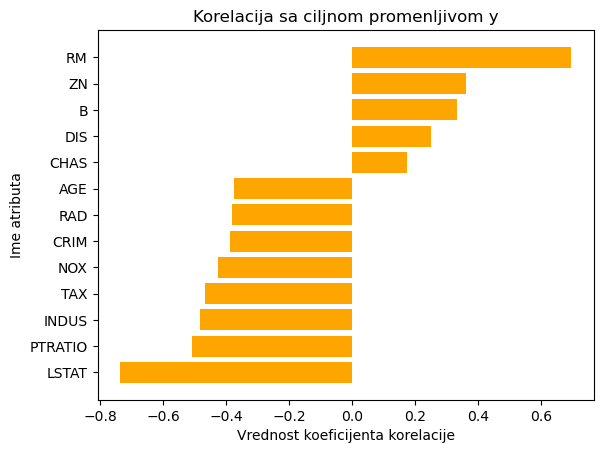

In [11]:
sorted_indicies = np.argsort(corrcoefs)

plt.title("Korelacija sa ciljnom promenljivom y")
plt.barh(
    np.arange(number_of_features),    
    np.array(corrcoefs)[sorted_indicies], 
    color='orange',
)
plt.ylabel('Ime atributa')
plt.xlabel('Vrednost koeficijenta korelacije')
plt.yticks(
    np.arange(number_of_features),
    feature_names[sorted_indicies],
)
plt.show()

Izdvojimo sada atribute koji imaju koeficijent korelacije veći od 0.4. Ovi atributi su dobri prediktori vrednosti ciljne promenljive. 

In [12]:
feature_names[np.abs(corrcoefs) > 0.4]

array(['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype='<U7')

Ispitajmo dalje linearnu zavisnost atributa između sebe. Podsetimo se da korelisanost atributa između sebe utiče na uslovljenost matrice sistema koji se rešava i dalje na numeričku stabilnost rešenja.

Za izračunavanje matrice korelacije možemo iskoristiti funkciju `corr`.

In [13]:
X.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


Zbog lakšeg praćenja, ove vrednosti se često prikazuju u formi toplotne mape. 

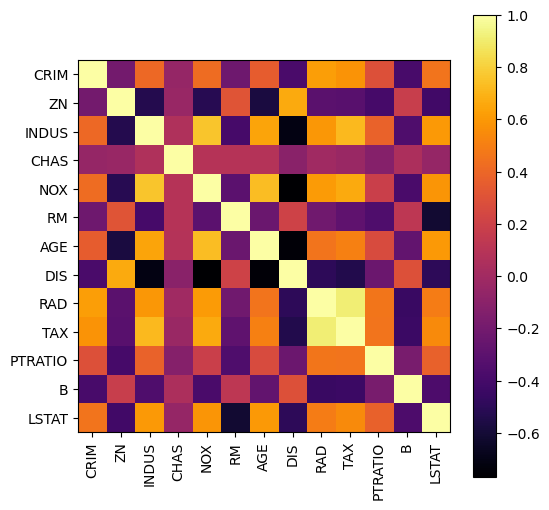

In [14]:
plt.figure(figsize=(6, 6))
plt.xticks(range(0, number_of_features), feature_names, rotation='vertical')
plt.yticks(range(0, number_of_features), feature_names)
plt.imshow(X.corr(), cmap='inferno')
plt.colorbar()
plt.show()

Takođe, zbog lakšeg praćenja, vrednosti koeficijenata korelacije koje su manje od neke očekivane vrednosti se mogu anulirati.

In [15]:
def correlation_strength(value, threshold=0.5):
    if value < threshold:
        return 0
    return value

In [16]:
X.corr().map(correlation_strength)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.625505,0.582764,0.0,0.0,0.000000
ZN,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.664408,0.000000,0.000000,0.0,0.0,0.000000
INDUS,0.000000,0.000000,1.000000,0.0,0.763651,0.0,0.644779,0.000000,0.595129,0.720760,0.0,0.0,0.603800
CHAS,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
NOX,0.000000,0.000000,0.763651,0.0,1.000000,0.0,0.731470,0.000000,0.611441,0.668023,0.0,0.0,0.590879
RM,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
AGE,0.000000,0.000000,0.644779,0.0,0.731470,0.0,1.000000,0.000000,0.000000,0.506456,0.0,0.0,0.602339
DIS,0.000000,0.664408,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000
RAD,0.625505,0.000000,0.595129,0.0,0.611441,0.0,0.000000,0.000000,1.000000,0.910228,0.0,0.0,0.000000
TAX,0.582764,0.000000,0.720760,0.0,0.668023,0.0,0.506456,0.000000,0.910228,1.000000,0.0,0.0,0.543993


Na primer, vrednosti korelacije između atributa `RAD` i `TAX` se može očitati na sledeći način:

In [17]:
X.corr().loc['RAD']['TAX']

0.9102281885331865

Na primer, vrednosti korelacije između atributa `TAX`, `INDUS`, `NOX`, `AGE`, `LSTAT` se mogu dobiti na sledeći način:

In [18]:
X[['TAX', 'INDUS', 'NOX', 'AGE','LSTAT']].corr()

,TAX,INDUS,NOX,AGE,LSTAT
TAX,1.000000,0.720760,0.668023,0.506456,0.543993
INDUS,0.720760,1.000000,0.763651,0.644779,0.603800
NOX,0.668023,0.763651,1.000000,0.731470,0.590879
AGE,0.506456,0.644779,0.731470,1.000000,0.602339
LSTAT,0.543993,0.603800,0.590879,0.602339,1.000000


Na primer, vrednosti korelacije imeđu atributa `RM`, `PTRATIO`, `LSTAT` se mogu dobiti na sledeći način:

In [19]:
X[['RM', 'PTRATIO', 'LSTAT']].corr()

,RM,PTRATIO,LSTAT
RM,1.000000,-0.355501,-0.613808
PTRATIO,-0.355501,1.000000,0.374044
LSTAT,-0.613808,0.374044,1.000000


Zapažanja koja možemo izvesti su: 
- `TAX` i `RAD` su visoko korelisani atributi pa jedan od ovih atributa može da se eliminiše
- `TAX` i `INUDS` su značajno korelisani 
- među prethodno izdvojenim atributima `RM` i `LSTAT` su korelisani

Ukoliko je potrebno obrisati neki od atributa iz skupa atributa, može se iskoristiti funkcija `drop`. Parametrom `labels` se navode imena kolona koje treba odabrati, a parametrom `inplace` da li brisanje treba izvesti u mestu ili ne. 

In [20]:
# X.drop(labels = ['RM'], axis = 1, inplace= True)

#### Novi model:

Izdvojićemo nekoliko atributa u skladu sa gornjim zaključcima i pripremiti podatke za rad.

In [21]:
X_subset = raw_data[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
# X_subset = raw_data[['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']]

In [22]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_subset, y, test_size = 0.33, random_state = 7)

In [23]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Obučićemo model nad ovako dobijenim skupom.

In [24]:
model = linear_model.LinearRegression()

In [25]:
model.fit(X_train_scaled, y_train)

LinearRegression()

Parametri naučenog modela su:

In [26]:
model.coef_

array([-0.05404711,  1.08336391, -0.93811133,  0.86331282, -2.31339677,
        0.94660679, -3.36106134,  0.40692875, -2.40425259,  0.3006918 ,
       -5.86957689])

In [27]:
model.intercept_

22.64306784660767

Koeficijent determinacije modela je:

In [28]:
model.score(X_test_scaled, y_test)

0.7061947822410025

U odnosu na polazni model sa skorom 0.5844375463291134, dobili smo model sa skorom 0.7061947822410024.

## Rekurzivna eliminacija atributa

Rekurzivna elminacija atributa (engl. Recursive Feature Elimination, RFE) je rekurzivna tehnika kojom se vrši ocena važnosti atributa. U svakom koraku ovog algoritma uči se zadati linearni model, a zatim se eliminiše najmanje važan atribut na osnovu vrednosti izračunatih koeficijenata.  

Na nivou biblioteke, ovaj algoritam je dostupan kroz klasu `RFE` paketa `feature_selection` i njene metode `fit` i `transform`.

In [29]:
from sklearn import feature_selection

Prvo ćemo ponovo učitati podatke i pripremiti ih za rad.

In [30]:
X = raw_data[feature_names]

In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 7)

In [32]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Naš model je model linearne regresije, a isti postupak se može svesti i na, na primer, model logističke regresije i druge linearne modele. 

In [33]:
model = linear_model.LinearRegression()

Pored modela koji treba da koristi `RFE` konstruktorska funkcija očekuje i broj atributa koje treba zadržati. Njega zadajemo atributom `n_features_to_select`. Mi ćemo se opredeliti za zadržavanje 10 atributa polaznog skupa, a u praksi bi se probalo sa više različitih vrednosti i odabrala bi se ona vrednost za koju se dobijaju najbolji rezultati. 

In [34]:
rfe = feature_selection.RFE(model, n_features_to_select=10, verbose=1)

In [35]:
rfe.fit(X_train_scaled, y_train)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFE(estimator=LinearRegression(), n_features_to_select=10, verbose=1)

Informacije o atributima koji su zadržani mogu se dobiti preko `support_` svojstva.

In [36]:
rfe.support_

array([ True, False, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True])

Dalje ćemo upariti imena atributa i indikatore da li ih treba zadržati ili ne.

In [37]:
for feature, support_indicator in zip(feature_names, rfe.support_):
    print (feature, support_indicator)

CRIM True
ZN False
INDUS False
CHAS True
NOX True
RM True
AGE False
DIS True
RAD True
TAX True
PTRATIO True
B True
LSTAT True


Alternativno, imena atributa koje treba zadržati možemo dobiti i na ovaj način:

In [38]:
keep_features = feature_names[rfe.support_]
keep_features

array(['CRIM', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
       'LSTAT'], dtype='<U7')

Komplementarno, imena atributa koji nisu uzeti u obzir se mogu dobiti sa:

In [39]:
delete_features = feature_names[~rfe.support_]
delete_features

array(['ZN', 'INDUS', 'AGE'], dtype='<U7')

Pomoću svojstva `ranking_` može se pročitati i redosled kojim su atributi izbacivani: prvo je izbačen atribut `INDUS`, pa atribut `B`, pa atribut `AGE`. 

In [40]:
rfe.ranking_

array([1, 2, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1])

Modifikovani skupovi podataka se mogu dobiti poizvom funkcije `fit`. U njima će biti zadržani samo odabrani atributi.

In [41]:
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

In [42]:
X_train_rfe.shape

(339, 10)

Dalje ćemo nad ovako izdvojenim skupom naučiti model i oceniti njegove performanse.

In [43]:
model.fit(X_train_rfe, y_train)

LinearRegression()

In [44]:
model.score(X_test_rfe, y_test)

0.6594210896617347

U odnosu na polazni model sa skorom 0.5844375463291134, dobili smo model sa skorom 0.6594210896617346.

Efekat eliminacije nekih atributa se može postići i korišćenjem specifičnih `regularizacija` modela. Na primer, `Laso` regularizacija je jedna takva vrsta regularizacije. 

<div class='alert alert-info'>
Zadatak:
    
Ispitati kako se model ponaša ukoliko se zadrži 7, 8 ili 9 atributa.
</div>